In [1]:
%load_ext autoreload
%autoreload 2

import torch as t
import requests
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [5]:
device = t.device("cuda:3" if t.cuda.is_available() else "cpu")

In [6]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


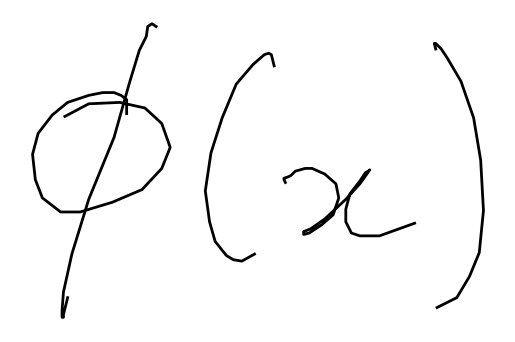

In [7]:
raw_image = Image.open("../img_data/inkML_data_CROHME_training_2011_formulaire001-equation001.inkml_0.png").convert('RGB')
raw_image

### Before Finetuning:

In [8]:
pixel_values = processor(images = raw_image, return_tensors="pt").pixel_values.to(device)
generated_ids = model.generate(pixel_values)
print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

/home/will/.conda/envs/torch2/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


p ( see ).


### Pretraining step on large dataset (rendered LaTeX)

#### Process data (run ONCE!)

In [10]:
# Load LST files
import pandas as pd
import numpy as np
import re
from tqdm import tqdm, trange

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula

train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
val_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_validate.lst", sep=" ", index_col = 0, header = None)
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()
invalid_train_images = []
for index in tqdm(train_filenames_df.index):
    formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[index, 1] + ".png").convert('RGBA')
    try: crop_to_formula(formula_image_example)
    except: invalid_train_images.append(index)
print("Invalid train images: ", len(invalid_train_images))

train_filenames_df = train_filenames_df.drop(invalid_train_images)
invalid_val_images = []
for index in tqdm(val_filenames_df.index):
    formula_image_example = Image.open("../formula_images/" + val_filenames_df.loc[index, 1] + ".png").convert('RGBA')
    try: crop_to_formula(formula_image_example)
    except: invalid_val_images.append(index)
val_filenames_df = val_filenames_df.drop(invalid_val_images)
print("Invalid val images: ", len(invalid_val_images))

invalid_idxs = set(invalid_train_images + invalid_val_images)

formulas = [i for index, i in enumerate(formulas) if index not in invalid_idxs]

print("Number of training formulas: ", len(train_filenames_df))
print("Number of validation formulas: ", len(val_filenames_df))
max_len = max([len(formula) for formula in formulas])
print("Max length:", max_len)

  0%|          | 4/83884 [00:00<40:12, 34.77it/s]

100%|██████████| 83884/83884 [41:06<00:00, 34.02it/s]


Invalid train images:  229


100%|██████████| 9320/9320 [04:31<00:00, 34.35it/s]

Invalid val images:  23
Number of training formulas:  83655
Number of validation formulas:  9297


AssertionError: 

#### Training:

In [93]:
# Load LST files
import pandas as pd
import numpy as np
import re
from tqdm import tqdm, trange

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula

train_filenames_df = pd.read_csv("../rendered_LaTeX/processed_im2latex_train.lst", index_col = 0, header = None, sep = " ")
val_filenames_df = pd.read_csv("../rendered_LaTeX/processed_im2latex_val.lst", index_col = 0, header = None, sep = " ")
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()

print("Number of training formulas: ", len(train_filenames_df))
print("Number of validation formulas: ", len(val_filenames_df))

max_len = max([len(formula) for formula in formulas])
print("Max length:", max_len)

Number of training formulas:  83655
Number of validation formulas:  9296
Max length: 998


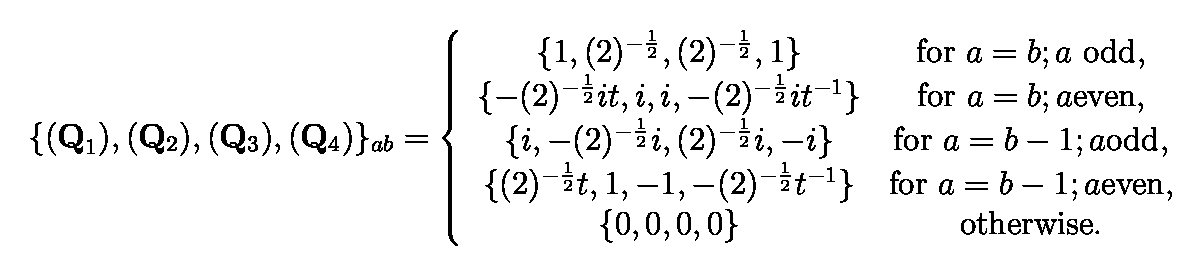

<IPython.core.display.Math object>

\{({\bf Q}_{1}),({\bf Q}_{2}),({\bf Q}_{3}),({\bf Q}_{4})\}_{ab}=\left\{\begin{array}{cc}\{1,(2)^{-\frac{1}{2}},(2)^{-\frac{1}{2}},1\}&\mbox{for }a=b; a\mbox{ odd,}\\\{-(2)^{-\frac{1}{2}}it,i,i,-(2)^{-\frac{1}{2}}it^{-1}\}&\mbox{for }a=b;a\mbox{even,}\\\{i,-(2)^{-\frac{1}{2}}i,(2)^{-\frac{1}{2}}i,-i\}&\mbox{for }a=b-1; a\mbox{odd,}\\\{(2)^{-\frac{1}{2}}t,1,-1,-(2)^{-\frac{1}{2}}t^{-1}\}&\mbox{for }a=b-1;a\mbox{even,}\\\{0,0,0,0\}&\mbox{otherwise.}\end{array}\right.



In [99]:
random_idx = np.random.choice(train_filenames_df.index)
formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[random_idx, 1] + ".png").convert('RGBA')

display(crop_to_formula(formula_image_example))
from IPython.display import display, Math, Latex
display_formula(renderedLaTeXLabelstr2Formula(formulas[random_idx]))
print(renderedLaTeXLabelstr2Formula(formulas[random_idx]))

<Axes: ylabel='Count'>

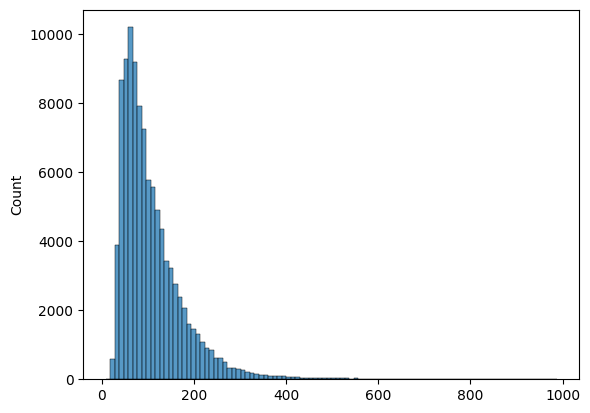

In [100]:
import seaborn as sns
formula_lengths = [len(renderedLaTeXLabelstr2Formula(formula)) for formula in formulas]
sns.histplot(formula_lengths, bins = 100)

In [101]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl

def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

class renderedLaTeXDataset(Dataset):
    def __init__(self, image_folder, lst_file, formulas_file, processor, device = device, cutoff = None):
        self.image_folder = image_folder
        self.lst_file = lst_file
        self.formulas_file = formulas_file
        self.train_filenames_df = pd.read_csv(self.lst_file, sep=" ", index_col = 0, header = None)
        self.formulas = open(self.formulas_file, encoding = "ISO-8859-1", newline="\n").readlines()
        self.processor = processor
        self.device = device
        self.cutoff = cutoff if cutoff else len(self.train_filenames_df)
        if cutoff is not None:
            self.train_filenames_df = self.train_filenames_df.iloc[:self.cutoff]
            self.formulas = self.formulas[:self.cutoff]
        
    def __len__(self):
        return self.cutoff
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.train_filenames_df.iloc[idx, 0] + ".png")
        image = Image.open(img_name).convert('RGBA')
        image = crop_to_formula(image)
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        formula_idx = self.train_filenames_df.iloc[idx].index[0]
        caption = renderedLaTeXLabelstr2Formula(self.formulas[formula_idx])
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 512, truncation = True, # Tweak this
            ).to(self.device).squeeze()
        
        return inputs, caption

In [102]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 2
LEARNING_RATE = 1e-5
BATCH_SIZE = 4 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = renderedLaTeXDataset(image_folder = "../formula_images/", 
                                lst_file = "../rendered_LaTeX/processed_im2latex_train.lst", 
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst", 
                                processor = processor)
val_ds = renderedLaTeXDataset(image_folder = "../formula_images/",
                                lst_file = "../rendered_LaTeX/processed_im2latex_val.lst",
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst",
                                processor = processor)
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = SHUFFLE_DATASET, num_workers = 0)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
print("Number of training samples:", len(train_ds))
print("Number of validation samples:", len(val_ds))

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass

Number of training samples: 83655
Number of validation samples: 9296


In [103]:
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.95
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/2:   0%|          | 0/20914 [00:00<?, ?it/s]

Epoch 1/2:   2%|▏         | 321/20914 [02:33<2:44:20,  2.09it/s, loss=0.0103]


KeyboardInterrupt: 

In [ ]:
# Save model
model.save_pretrained("../models/trocr-large-rendered-im2latex")
processor.save_pretrained("../models/trocr-large-rendered-im2latex")

### Finetuning:

In [6]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl

def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "../img_data", 
                 csv_file = "labels.csv",
                 transform = None, use_float16 = False,
                 device = device,
                 partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        if self.partition == "train": img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1])
        else: img_name = os.path.join(self.img_dir, self.labels_val.iloc[idx, 1])

        image = Image.open(img_name).convert('RGB')
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        if self.partition == "train": caption = self.labels.iloc[idx, 0]
        else: caption = self.labels_val.iloc[idx, 0]
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 256, # Tweak this, longest length in current dataset is 156
            ).to(self.device).squeeze()

        return inputs, caption

In [7]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
BATCH_SIZE = 8 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = MathCaptionsDataset(processor); train_ds.train()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_ds = MathCaptionsDataset(processor); val_ds.val()
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
assert (train_ds.labels_val.values == val_ds.labels_val.values).all()

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass

In [8]:
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.99
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/3:   0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 1/3:   1%|          | 12/1110 [00:06<09:44,  1.88it/s, loss=17.3]


KeyboardInterrupt: 

In [21]:
model.save_pretrained("trocr_model")
processor.save_pretrained("trocr_processor")

[]

In [5]:
# Load model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("trocr_model").to(device)
processor = TrOCRProcessor.from_pretrained("trocr_processor")

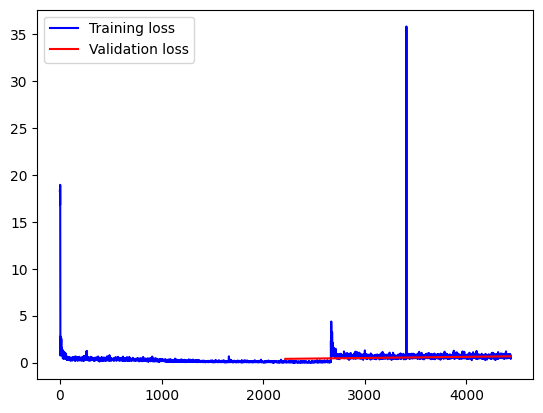

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data = history, color = "blue", label = "Training loss")
sns.lineplot(x = val_timesteps, y = val_history, color = "red", label = "Validation loss")
plt.legend()
plt.show()

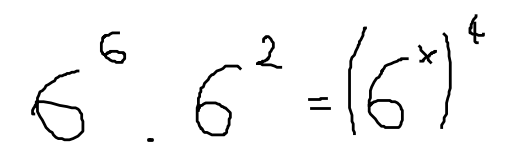

Prediction:



<IPython.core.display.Math object>

Gt:
${6^{6}} \cdot {6^{2}} = {( {6^{x}} )^{4}}$


<IPython.core.display.Math object>

In [9]:
import random
# Randomly select a validation image and caption
idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name).convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math, Latex
# Show image
display(image)

pixel_values = processor(images = image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens = 256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))
print("Gt:")
print(caption)
display(Math(caption))

### Validation on REAL handwritten digits

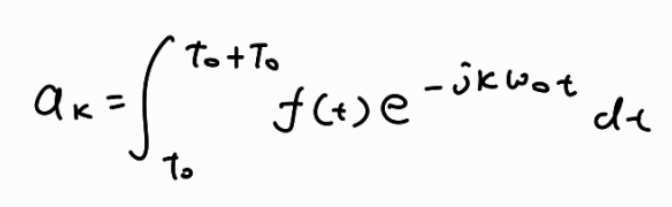

Prediction:
$a_k = \int^{\pi + \beta f(x)e^{-j^{-j}}$


<IPython.core.display.Math object>

In [51]:
import random
image = Image.open("../demo/demo.png").convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math, Latex
# Show image
display(image)

pixel_values = processor(images = image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens = 256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))